## Question 2

Learn the following models on XOR dataset (refer to Tensorflow Playground and generate the dataset on your own containing 200 training instances and 200 test instances) such that all these models achieve similar results (good). The definition of good is left subjective – but you would expect the classifier to capture the shape of the XOR function. 

- a MLP
- MLP w/ L1 regularization (you may vary the penalty coefficient by choose the best one using a validation dataset)
- MLP w/ L2 regularization (you may vary the penalty coefficient by choose the best one using a validation dataset)
- learn logistic regression models on the same data with additional features (such as x1*x2, x1^2, etc.)

Show the decision surface and comment on the plots obtained for different models.


In [229]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

np.random.seed(42)
torch.manual_seed(42)

In [230]:
# Function to generate XOR dataset

def generate_xor_data(n_samples):
    X = np.random.uniform(-1, 1, size=(n_samples, 2))
    y = np.logical_xor(X[:, 0] > 0, X[:, 1] > 0).astype(int)
    return X, y

In [231]:
# Generating training and test data

X_train_np, y_train_np = generate_xor_data(200)
X_test_np, y_test_np = generate_xor_data(200)

X_train = torch.tensor(X_train_np, dtype=torch.float32)
y_train = torch.tensor(y_train_np, dtype=torch.float32).unsqueeze(1)

X_test = torch.tensor(X_test_np, dtype=torch.float32)
y_test = torch.tensor(y_test_np, dtype=torch.float32).unsqueeze(1)

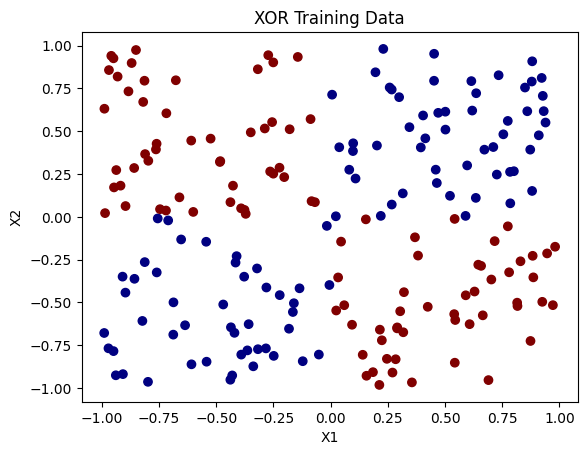

In [232]:
# Plot the training data

plt.scatter(X_train_np[:, 0], X_train_np[:, 1], c=y_train_np, cmap='jet')
plt.xlabel("X1")
plt.ylabel("X2")
plt.title('XOR Training Data')
plt.show()

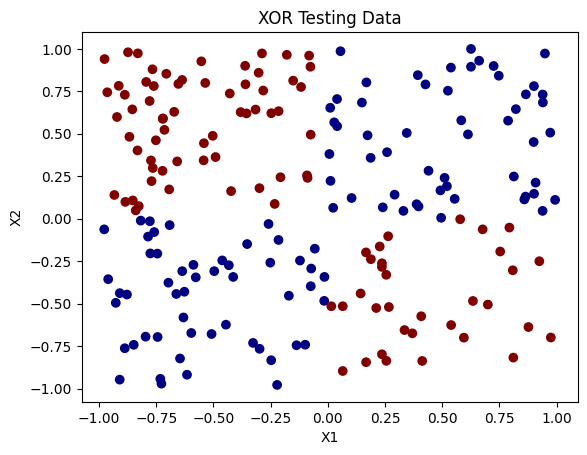

In [233]:
plt.scatter(X_test_np[:, 0], X_test_np[:, 1], c=y_test_np, cmap='jet')
plt.xlabel("X1")
plt.ylabel("X2")
plt.title('XOR Testing Data')
plt.show()

### a) Using MLP

In [234]:
# Defining MLP

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.lin1 = nn.Linear(2,10)
        self.lin2 = nn.Linear(10,1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self,x):
        x = torch.relu(self.lin1(x))
        x = self.sigmoid(self.lin2(x))
        return x

In [235]:
# Initializing the model, loss function and the optimizer

mlp = MLP()
criterion = nn.BCELoss()
optimizer = optim.AdamW(mlp.parameters(), lr=0.01)

In [236]:
for param_name, param in mlp.named_parameters():
    print(param_name, param.shape)

lin1.weight torch.Size([10, 2])
lin1.bias torch.Size([10])
lin2.weight torch.Size([1, 10])
lin2.bias torch.Size([1])


In [237]:
# Training loop

n_epochs = 2500
for epoch in range(n_epochs):
    mlp.train()
    optimizer.zero_grad()
    output = mlp(X_train)
    loss = criterion(output, y_train)
    loss.backward()
    optimizer.step()

    if (epoch+1) % 500 == 0:
        print(f'Epoch {epoch+1}, Loss: {loss.item():.6f}')

Epoch 500, Loss: 0.112392
Epoch 1000, Loss: 0.076062
Epoch 1500, Loss: 0.054683
Epoch 2000, Loss: 0.038689
Epoch 2500, Loss: 0.028305


In [238]:
# Plot decision boundary

def plot_decision_boundary(model, X, y, title):
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02), np.arange(y_min, y_max, 0.02))
    
    # Predict class labels for the grid points
    grid = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)
    with torch.no_grad():
        Z = model(grid).numpy()
        
    Z = Z.reshape(xx.shape)
    
    plt.contourf(xx, yy, Z, levels=[0, 0.5, 1], cmap='jet', alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap='jet')
    plt.title(title)
    plt.show()

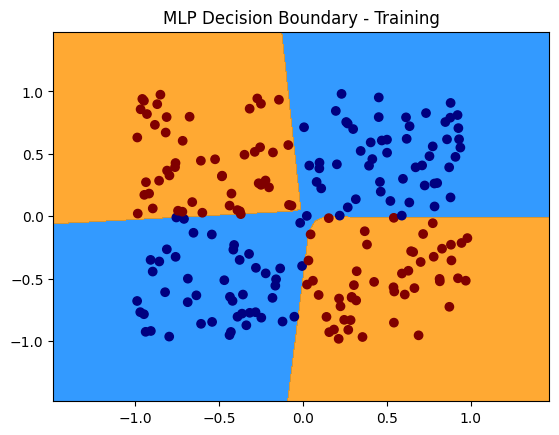

In [239]:
# Plot the decision boundary for the trained model
plot_decision_boundary(mlp, X_train_np, y_train_np, "MLP Decision Boundary - Training")

In [240]:
# Using the model on training data

mlp.eval()
with torch.no_grad():
    y_train_pred = mlp(X_train)
    y_train_pred_labels = (y_train_pred > 0.5).float()  # Threshold at 0.5 to get binary predictions

In [241]:
from sklearn.metrics import accuracy_score, classification_report

In [242]:
# Convert to NumPy for sklearn metrics
y_train_pred_labels_np = y_train_pred_labels.numpy()

# Calculate accuracy
accuracy = accuracy_score(y_train_np, y_train_pred_labels_np)
print(f"Train Accuracy: {accuracy * 100:.2f}%")

# Classification report for precision, recall, F1-score
print("Classification Report:")
print(classification_report(y_train_np, y_train_pred_labels_np))

Train Accuracy: 99.50%
Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       101
           1       1.00      0.99      0.99        99

    accuracy                           0.99       200
   macro avg       1.00      0.99      0.99       200
weighted avg       1.00      0.99      0.99       200



In [243]:
# Testing the model on testing data

mlp.eval()
with torch.no_grad():
    y_test_pred = mlp(X_test)
    y_test_pred_labels = (y_test_pred > 0.5).float()  # Threshold at 0.5 to get binary predictions

In [244]:
# Convert to NumPy for sklearn metrics
y_test_pred_labels_np = y_test_pred_labels.numpy()

# Calculate accuracy
accuracy = accuracy_score(y_test_np, y_test_pred_labels_np)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

# Classification report for precision, recall, F1-score
print("Classification Report:")
print(classification_report(y_test_np, y_test_pred_labels_np))

Test Accuracy: 98.00%
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       105
           1       0.99      0.97      0.98        95

    accuracy                           0.98       200
   macro avg       0.98      0.98      0.98       200
weighted avg       0.98      0.98      0.98       200



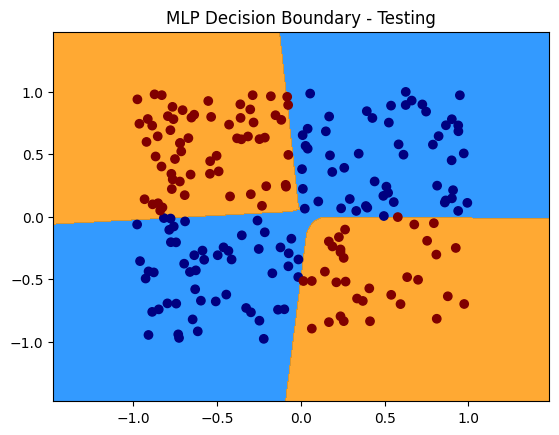

In [245]:
# Plot decision boundary for the test set
plot_decision_boundary(mlp, X_test.numpy(), y_test.numpy(), "MLP Decision Boundary - Testing")

In [246]:
import gc
gc.collect()

7307

### b) Using MLP with L1 Regularization

In [247]:
# Split into training and validation sets (75% train, 25% validation)

from sklearn.model_selection import train_test_split

X1_train_np, X1_val_np, y1_train_np, y1_val_np = train_test_split(X_train_np, y_train_np, test_size=0.25, random_state=42)

X1_train = torch.tensor(X1_train_np, dtype=torch.float32)
y1_train = torch.tensor(y1_train_np, dtype=torch.float32).unsqueeze(1)
X1_val = torch.tensor(X1_val_np, dtype=torch.float32)
y1_val = torch.tensor(y1_val_np, dtype=torch.float32).unsqueeze(1)

In [248]:
# L1 Regularization function
def l1_penalty(model, l1_lambda):
    l1_norm = 0.0
    for parameter in model.parameters():
        l1_norm += torch.sum(torch.abs(parameter))
    return l1_lambda * l1_norm

In [249]:
# Training loop with L1 regularization and validation
n_epochs = 2500
lambdas = [0.00001, 0.0001, 0.001, 0.01]

best_val_loss = float('inf')  # Initialize best validation loss
best_lambda = None  # To track the best lambda
best_model = None
for l1_lambda in lambdas:
    print(f"For L1 Lambda = {l1_lambda} -")
    mlp_l1 = MLP()
    criterion = nn.BCELoss()
    optimizer = optim.AdamW(mlp_l1.parameters(), lr=0.01)
    for epoch in range(n_epochs):
        mlp_l1.train()
        optimizer.zero_grad()
        output = mlp_l1(X1_train)
        loss = criterion(output, y1_train)
        l1_loss = l1_penalty(mlp_l1, l1_lambda)
        total_loss = loss + l1_loss
        total_loss.backward()
        optimizer.step()

        # Validation step
        mlp_l1.eval()
        with torch.no_grad():
            val_output = mlp_l1(X1_val)
            val_loss = criterion(val_output, y1_val)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_lambda = l1_lambda  # Track the best lambda
            best_model = mlp_l1

        if (epoch+1) % 500 == 0:
            print(f'Epoch {epoch+1}, Loss: {loss.item():.6f}, L1 Loss: {l1_loss.item():.6f}, Validation Loss: {val_loss.item():.6f}')

print(f"Best L1 Lambda: {best_lambda}, Best Validation Loss: {best_val_loss.item():.6f}")

For L1 Lambda = 1e-05 -
Epoch 500, Loss: 0.051047, L1 Loss: 0.000577, Validation Loss: 0.099285
Epoch 1000, Loss: 0.030366, L1 Loss: 0.000737, Validation Loss: 0.091720
Epoch 1500, Loss: 0.022122, L1 Loss: 0.000850, Validation Loss: 0.077857
Epoch 2000, Loss: 0.016838, L1 Loss: 0.000952, Validation Loss: 0.067285
Epoch 2500, Loss: 0.012821, L1 Loss: 0.001048, Validation Loss: 0.059320
For L1 Lambda = 0.0001 -
Epoch 500, Loss: 0.049887, L1 Loss: 0.005735, Validation Loss: 0.094854
Epoch 1000, Loss: 0.029907, L1 Loss: 0.007188, Validation Loss: 0.100294
Epoch 1500, Loss: 0.021721, L1 Loss: 0.008212, Validation Loss: 0.086342
Epoch 2000, Loss: 0.016388, L1 Loss: 0.009064, Validation Loss: 0.076196
Epoch 2500, Loss: 0.012543, L1 Loss: 0.009770, Validation Loss: 0.072520
For L1 Lambda = 0.001 -
Epoch 500, Loss: 0.058609, L1 Loss: 0.057011, Validation Loss: 0.099800
Epoch 1000, Loss: 0.043715, L1 Loss: 0.062762, Validation Loss: 0.093539
Epoch 1500, Loss: 0.038466, L1 Loss: 0.061205, Validat

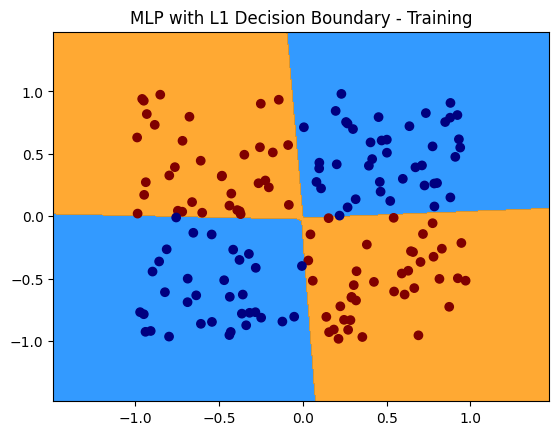

In [250]:
# Plot the decision boundary for the trained model
plot_decision_boundary(best_model, X1_train_np, y1_train_np, "MLP with L1 Decision Boundary - Training")

In [251]:
# Using the model on training data

best_model.eval()
with torch.no_grad():
    y_train_pred = best_model(X_train)
    y_train_pred_labels = (y_train_pred > 0.5).float()  # Threshold at 0.5 to get binary predictions

In [252]:
# Convert to NumPy for sklearn metrics
y_train_pred_labels_np = y_train_pred_labels.numpy()

# Calculate accuracy
accuracy = accuracy_score(y_train_np, y_train_pred_labels_np)
print(f'Train Accuracy: {accuracy * 100:.2f}%')

# Classification report for precision, recall, F1-score
print("Classification Report:")
print(classification_report(y_train_np, y_train_pred_labels_np))

Train Accuracy: 99.50%
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       101
           1       0.99      1.00      0.99        99

    accuracy                           0.99       200
   macro avg       0.99      1.00      0.99       200
weighted avg       1.00      0.99      1.00       200



In [253]:
# Testing the model on testing data

best_model.eval()
with torch.no_grad():
    y_test_pred = best_model(X_test)
    y_test_pred_labels = (y_test_pred > 0.5).float()  # Threshold at 0.5 to get binary predictions

In [254]:
# Convert to NumPy for sklearn metrics
y_test_pred_labels_np = y_test_pred_labels.numpy()

# Calculate accuracy
accuracy = accuracy_score(y_test_np, y_test_pred_labels_np)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

# Classification report for precision, recall, F1-score
print("Classification Report:")
print(classification_report(y_test_np, y_test_pred_labels_np))

Test Accuracy: 99.00%
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       105
           1       0.99      0.99      0.99        95

    accuracy                           0.99       200
   macro avg       0.99      0.99      0.99       200
weighted avg       0.99      0.99      0.99       200



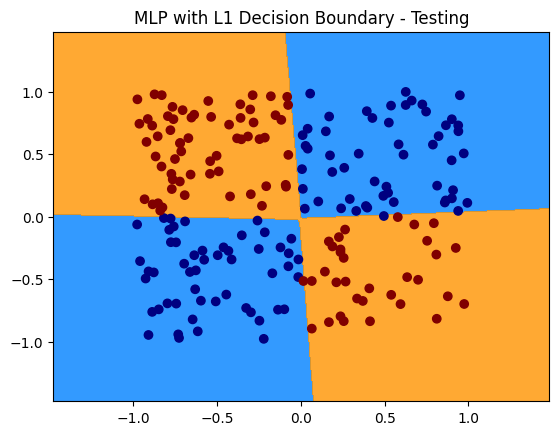

In [255]:
# Plot decision boundary for the test set
plot_decision_boundary(best_model, X_test.numpy(), y_test.numpy(), "MLP with L1 Decision Boundary - Testing")

In [256]:
gc.collect()

3363

### c) Using MLP with L2 Regularization

In [257]:
# L1 Regularization function
def l2_penalty(model, l2_lambda):
    l2_norm = 0.0
    for parameter in model.parameters():
        l2_norm += parameter.pow(2).sum()
    return l2_lambda * l2_norm

In [278]:
# Training loop with L2 regularization and validation
n_epochs = 3000
lambdas = [0.00001, 0.0001, 0.001, 0.01]

best_val_loss = float('inf')  # Initialize best validation loss
best_lambda = None  # To track the best lambda
best_model = None
for l2_lambda in lambdas:
    print(f"For L2 Lambda = {l2_lambda} -")
    mlp_l2 = MLP()
    criterion = nn.BCELoss()
    optimizer = optim.AdamW(mlp_l2.parameters(), lr=0.01)
    for epoch in range(n_epochs):
        mlp_l2.train()
        optimizer.zero_grad()
        output = mlp_l2(X1_train)
        loss = criterion(output, y1_train)
        l2_loss = l2_penalty(mlp_l2, l2_lambda)
        total_loss = loss + l2_loss
        total_loss.backward()
        optimizer.step()

        # Validation step
        mlp_l2.eval()
        with torch.no_grad():
            val_output = mlp_l2(X1_val)
            val_loss = criterion(val_output, y1_val)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_lambda = l2_lambda  # Track the best lambda
            best_model = mlp_l2

        if (epoch+1) % 500 == 0:
            print(f'Epoch {epoch+1}, Loss: {loss.item():.6f}, L2 Loss: {l1_loss.item():.6f}, Validation Loss: {val_loss.item():.6f}')

print(f"Best L2 Lambda: {best_lambda}, Best Validation Loss: {best_val_loss.item():.6f}")

For L2 Lambda = 1e-05 -
Epoch 500, Loss: 0.051793, L2 Loss: 0.072707, Validation Loss: 0.124672
Epoch 1000, Loss: 0.028283, L2 Loss: 0.072707, Validation Loss: 0.213747
Epoch 1500, Loss: 0.019689, L2 Loss: 0.072707, Validation Loss: 0.268298
Epoch 2000, Loss: 0.013694, L2 Loss: 0.072707, Validation Loss: 0.324537
Epoch 2500, Loss: 0.009379, L2 Loss: 0.072707, Validation Loss: 0.371941
Epoch 3000, Loss: 0.007136, L2 Loss: 0.072707, Validation Loss: 0.416289
For L2 Lambda = 0.0001 -
Epoch 500, Loss: 0.060798, L2 Loss: 0.072707, Validation Loss: 0.106666
Epoch 1000, Loss: 0.038065, L2 Loss: 0.072707, Validation Loss: 0.107014
Epoch 1500, Loss: 0.032556, L2 Loss: 0.072707, Validation Loss: 0.105485
Epoch 2000, Loss: 0.030464, L2 Loss: 0.072707, Validation Loss: 0.100499
Epoch 2500, Loss: 0.029380, L2 Loss: 0.072707, Validation Loss: 0.096691
Epoch 3000, Loss: 0.028669, L2 Loss: 0.072707, Validation Loss: 0.093162
For L2 Lambda = 0.001 -
Epoch 500, Loss: 0.091570, L2 Loss: 0.072707, Validat

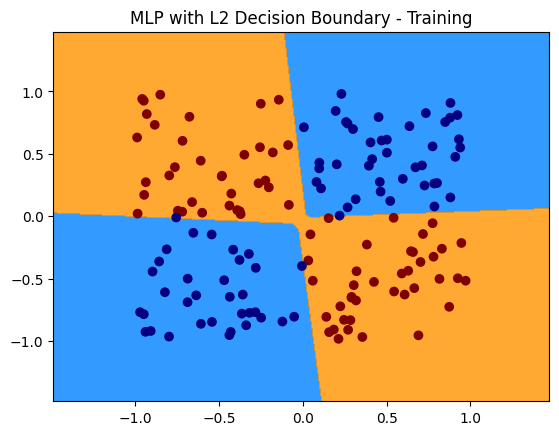

In [279]:
# Plot the decision boundary for the trained model
plot_decision_boundary(best_model, X1_train_np, y1_train_np, "MLP with L2 Decision Boundary - Training")

In [280]:
# Using the model on training data

best_model.eval()
with torch.no_grad():
    y_train_pred = best_model(X_train)
    y_train_pred_labels = (y_train_pred > 0.5).float()  # Threshold at 0.5 to get binary predictions

In [281]:
# Convert to NumPy for sklearn metrics
y_train_pred_labels_np = y_train_pred_labels.numpy()

# Calculate accuracy
accuracy = accuracy_score(y_train_np, y_train_pred_labels_np)
print(f'Train Accuracy: {accuracy * 100:.2f}%')

# Classification report for precision, recall, F1-score
print("Classification Report:")
print(classification_report(y_train_np, y_train_pred_labels_np))

Train Accuracy: 98.50%
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.98       101
           1       0.97      1.00      0.99        99

    accuracy                           0.98       200
   macro avg       0.99      0.99      0.98       200
weighted avg       0.99      0.98      0.98       200



In [282]:
# Testing the model on testing data

best_model.eval()
with torch.no_grad():
    y_test_pred = best_model(X_test)
    y_test_pred_labels = (y_test_pred > 0.5).float()  # Threshold at 0.5 to get binary predictions

In [283]:
# Convert to NumPy for sklearn metrics
y_test_pred_labels_np = y_test_pred_labels.numpy()

# Calculate accuracy
accuracy = accuracy_score(y_test_np, y_test_pred_labels_np)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

# Classification report for precision, recall, F1-score
print("Classification Report:")
print(classification_report(y_test_np, y_test_pred_labels_np))

Test Accuracy: 97.50%
Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.96      0.98       105
         1.0       0.96      0.99      0.97        95

    accuracy                           0.97       200
   macro avg       0.97      0.98      0.97       200
weighted avg       0.98      0.97      0.98       200



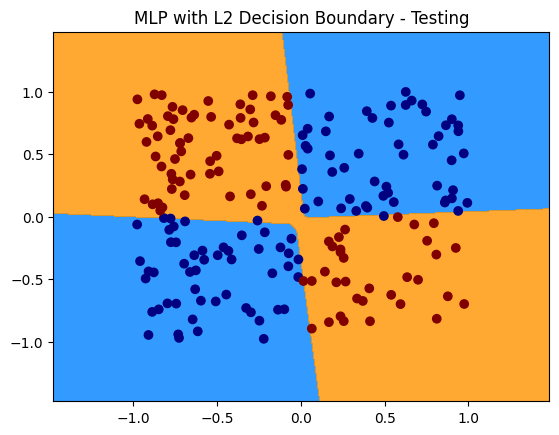

In [284]:
# Plot decision boundary for the test set
plot_decision_boundary(best_model, X_test.numpy(), y_test.numpy(), "MLP with L2 Decision Boundary - Testing")

In [285]:
gc.collect()

3341

### d) Using Logistic Regression with Additional Features

In [266]:
# Adding additional features (x1*x2, x1^2, x2^2) to the training and testing dataset

X_lr_train_np = X_train.numpy()
X1X2 = np.zeros(len(X_lr_train_np))
X1sq = np.zeros(len(X_lr_train_np))
X2sq = np.zeros(len(X_lr_train_np))

for i in range(len(X1X2)):
    X1X2[i] = X_lr_train_np[i][0]*X_lr_train_np[i][1]
    X1sq[i] = X_lr_train_np[i][0]**2
    X2sq[i] = X_lr_train_np[i][1]**2
    
X1X2 = X1X2.reshape(-1,1)
X1sq = X1sq.reshape(-1,1)
X2sq = X2sq.reshape(-1,1)
    
X_lr_train_np = np.hstack((X_lr_train_np, X1X2, X1sq, X2sq))
X_lr_train = torch.tensor(X_lr_train_np, dtype=torch.float32)
print("Train data shape =", X_lr_train.shape)
    
X_lr_test_np = X_test.numpy()
X1X2 = np.zeros(len(X_lr_test_np))
X1sq = np.zeros(len(X_lr_test_np))
X2sq = np.zeros(len(X_lr_test_np))

for i in range(len(X1X2)):
    X1X2[i] = X_lr_test_np[i][0]*X_lr_test_np[i][1]
    X1sq[i] = X_lr_test_np[i][0]**2
    X2sq[i] = X_lr_test_np[i][1]**2
    
X1X2 = X1X2.reshape(-1,1)
X1sq = X1sq.reshape(-1,1)
X2sq = X2sq.reshape(-1,1)
    
X_lr_test_np = np.hstack((X_lr_test_np, X1X2, X1sq, X2sq))
X_lr_test = torch.tensor(X_lr_test_np, dtype=torch.float32)
print("Test data shape =", X_lr_train.shape)

Train data shape = torch.Size([200, 5])
Test data shape = torch.Size([200, 5])


In [267]:
# Defining Logistic Regression (LR)

class LR(nn.Module):
    def __init__(self):
        super(LR, self).__init__()
        self.linear = nn.Linear(5,1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self,x):
        out = self.linear(x)
        out = self.sigmoid(out)
        return out

In [268]:
# Initializing the model, loss function and the optimizer

logistic_reg = LR()
criterion = nn.BCELoss()
optimizer = optim.AdamW(logistic_reg.parameters(), lr=0.01)

In [269]:
# Training loop

n_epochs = 5000
for epoch in range(n_epochs):
    logistic_reg.train()
    optimizer.zero_grad()
    output = logistic_reg(X_lr_train)
    loss = criterion(output, y_train)
    loss.backward()
    optimizer.step()

    if (epoch+1) % 500 == 0:
        print(f'Epoch {epoch+1}, Loss: {loss.item():.6f}')

Epoch 500, Loss: 0.382582
Epoch 1000, Loss: 0.285228
Epoch 1500, Loss: 0.236518
Epoch 2000, Loss: 0.206079
Epoch 2500, Loss: 0.184684
Epoch 3000, Loss: 0.168462
Epoch 3500, Loss: 0.155489
Epoch 4000, Loss: 0.144705
Epoch 4500, Loss: 0.135479
Epoch 5000, Loss: 0.127415


In [270]:
def logistic_decision_boundary(model, X, y, title):
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02), np.arange(y_min, y_max, 0.02))
    
    # Create the grid and add new features (x1 * x2, x1^2, x2^2)
    grid = np.c_[xx.ravel(), yy.ravel()]
    
    # Add the new features
    X1X2 = grid[:, 0] * grid[:, 1]
    X1sq = grid[:, 0]**2
    X2sq = grid[:, 1]**2
    
    # Combine the original grid with the new features
    grid_with_features = np.hstack((grid, X1X2.reshape(-1, 1), X1sq.reshape(-1, 1), X2sq.reshape(-1, 1)))
    
    # Convert to a PyTorch tensor
    grid_with_features = torch.tensor(grid_with_features, dtype=torch.float32)
    
    # Predict class labels for the grid points
    with torch.no_grad():
        Z = model(grid_with_features).numpy()
        
    Z = Z.reshape(xx.shape)
    
    plt.contourf(xx, yy, Z, levels=[0, 0.5, 1], cmap='jet', alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap='jet')
    plt.title(title)
    plt.show()


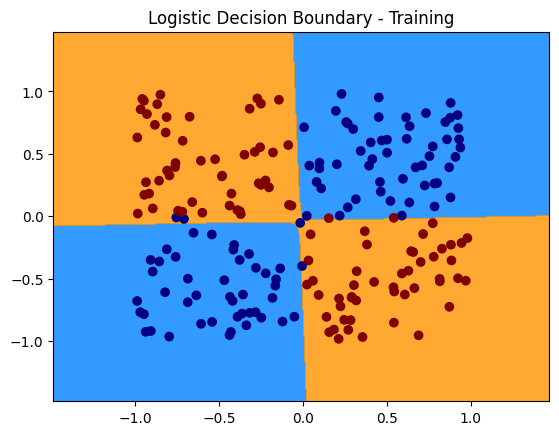

In [271]:
# Plot the decision boundary for the trained model
logistic_decision_boundary(logistic_reg, X_lr_train_np, y_train_np, "Logistic Decision Boundary - Training")

In [272]:
# Using the model on training data

logistic_reg.eval()
with torch.no_grad():
    y_train_pred = logistic_reg(X_lr_train)
    y_train_pred_labels = (y_train_pred > 0.5).float()  # Threshold at 0.5 to get binary predictions

In [273]:
# Convert to NumPy for sklearn metrics
y_train_pred_labels_np = y_train_pred_labels.numpy()

# Calculate accuracy
accuracy = accuracy_score(y_train_np, y_train_pred_labels_np)
print(f'Train Accuracy: {accuracy * 100:.2f}%')

# Classification report for precision, recall, F1-score
print("Classification Report:")
print(classification_report(y_train_np, y_train_pred_labels_np))

Train Accuracy: 97.00%
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.96      0.97       101
           1       0.96      0.98      0.97        99

    accuracy                           0.97       200
   macro avg       0.97      0.97      0.97       200
weighted avg       0.97      0.97      0.97       200



In [274]:
# Testing the model on testing data

logistic_reg.eval()
with torch.no_grad():
    y_test_pred = logistic_reg(X_lr_test)
    y_test_pred_labels = (y_test_pred > 0.5).float()  # Threshold at 0.5 to get binary predictions

In [275]:
# Convert to NumPy for sklearn metrics
y_test_np = y_test.numpy()
y_test_pred_labels_np = y_test_pred_labels.numpy()

# Calculate accuracy
accuracy = accuracy_score(y_test_np, y_test_pred_labels_np)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

# Classification report for precision, recall, F1-score
print("Classification Report:")
print(classification_report(y_test_np, y_test_pred_labels_np))

Test Accuracy: 97.00%
Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.95      0.97       105
         1.0       0.95      0.99      0.97        95

    accuracy                           0.97       200
   macro avg       0.97      0.97      0.97       200
weighted avg       0.97      0.97      0.97       200



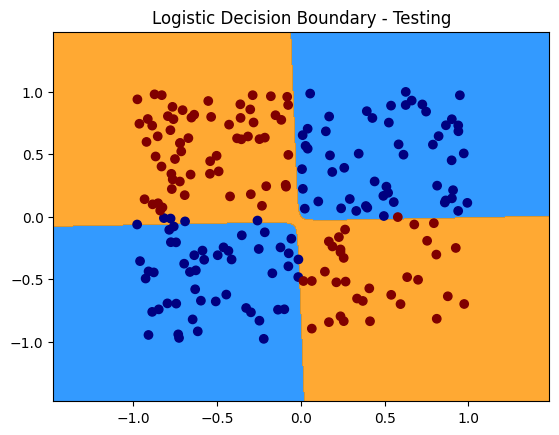

In [276]:
# Plot the decision boundary for the test set
logistic_decision_boundary(logistic_reg, X_lr_test_np, y_test_np, "Logistic Decision Boundary - Testing")

In [277]:
gc.collect()

3366